Using the cleveland dataset determine optimal values of k and an optimal set of attributes to use to maximize predictive power in predicting if a patient has heart disease or not.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")




In [50]:
# Comma-separated values
df = pd.read_csv('data/cleveland.csv')

# Rename 'num' column to 'disease' and change 1,2,3,4 to 1
df = df.rename({'num':'disease'}, axis=1)
df['disease'] = df.disease.apply(lambda x: min(x, 1))
display(df.head(5))
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,disease
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


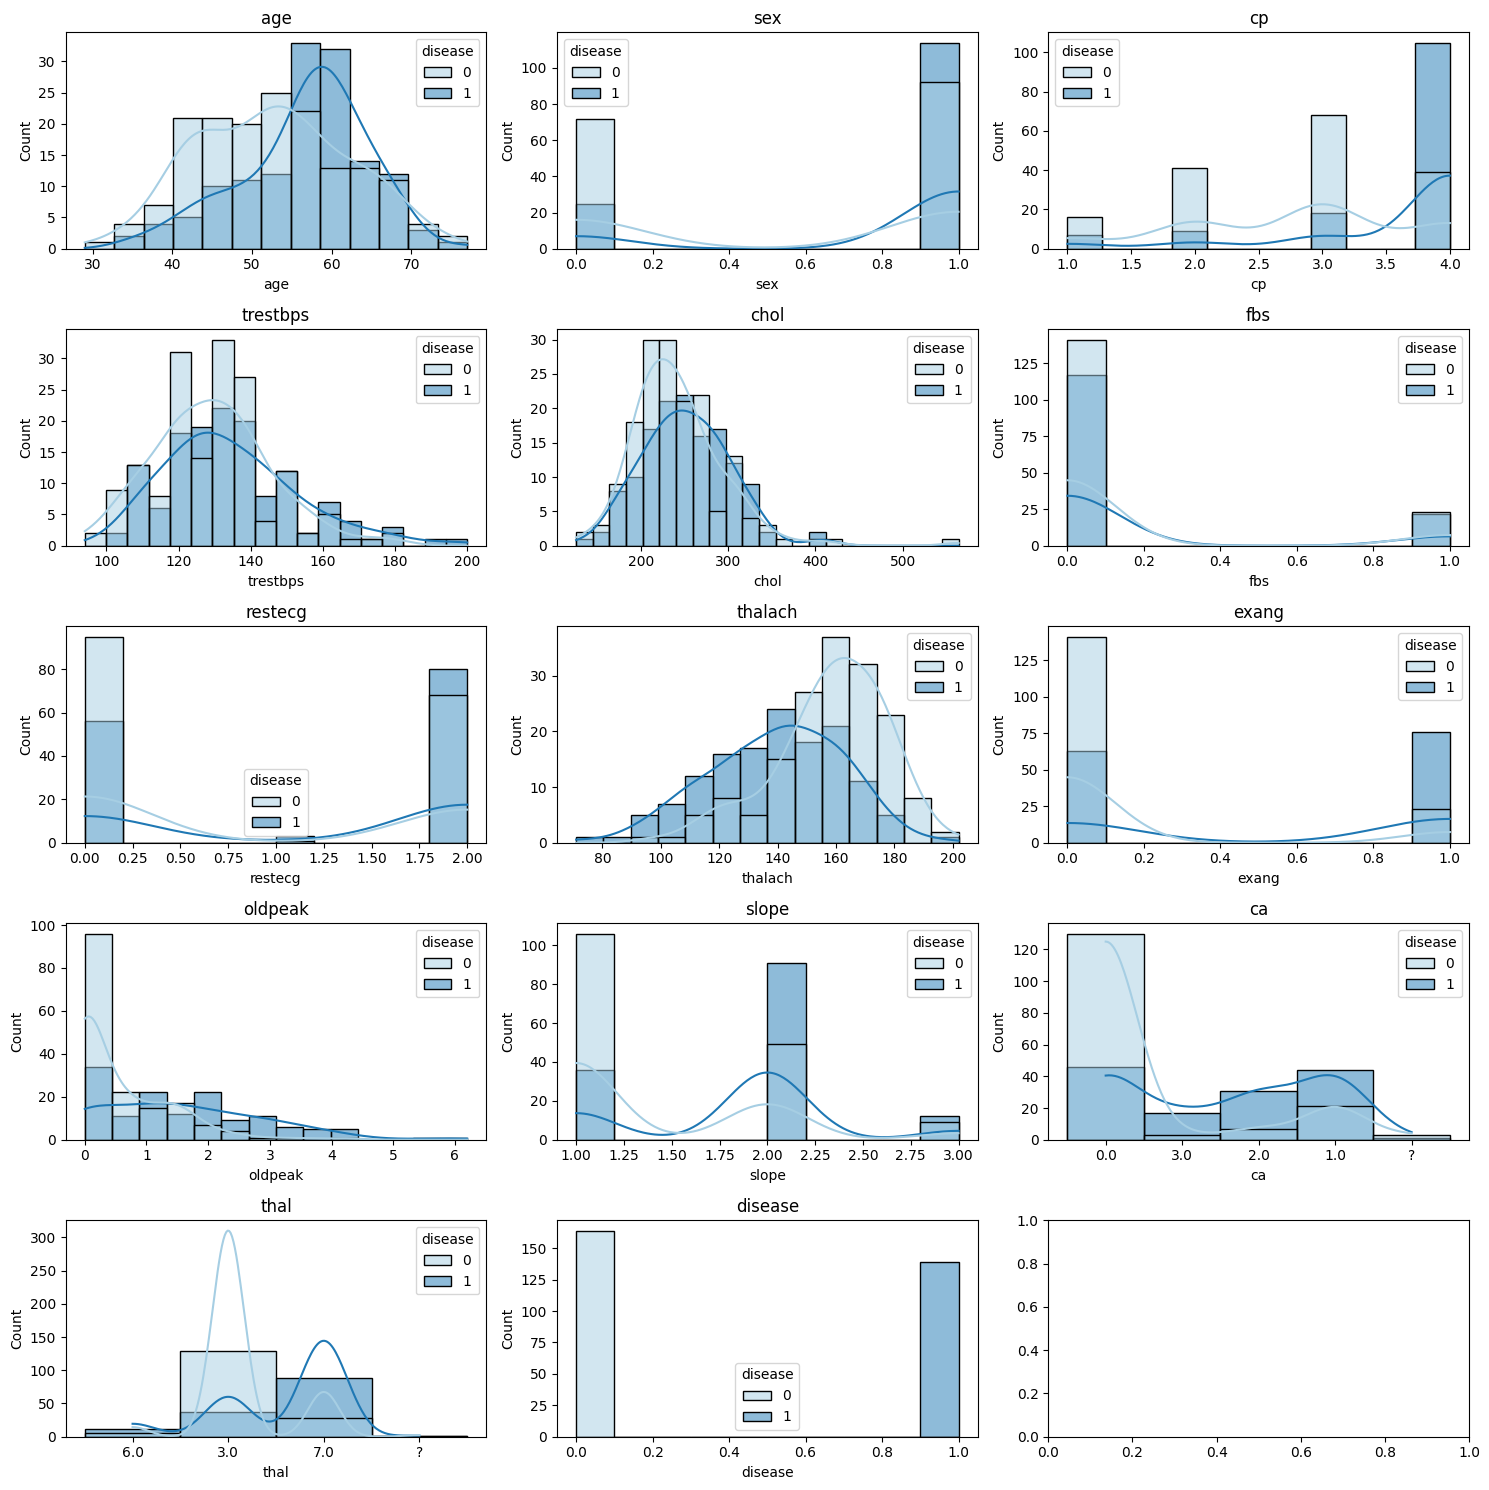

sex
1.0    206
0.0     97
Name: count, dtype: int64


In [51]:
# Plot histograms for all features
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
palette = sns.color_palette("Paired",5)
# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each feature and create a histogram
for i, feature in enumerate(df.columns):
        sns.histplot(data=df, x=feature, hue='disease', ax=axes[i], kde=True, palette=palette)
        axes[i].set_title(feature)  # Set title for each subplot

# Adjust layout
plt.tight_layout()
plt.show()
print(df['sex'].value_counts())

In [52]:
from inspect import cleandoc
# Replace '?' with NaN
df_numeric = df.replace('?', np.nan)

# Impute missing values with the median
clean = SimpleImputer(strategy='median')
df_clean = pd.DataFrame(clean.fit_transform(df_numeric), columns=df_numeric.columns)

In [53]:
# Convert columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

#covariance and variance
cov_matrix = df.cov()
variance = df.var()
print(cov_matrix)
print(variance)
# Feature selection based on covariance and variance
# Choose features with high covariance with the target variable and high variance
selected_features = []
for feature in df.columns[:-1]:
    #print(cov_matrix.loc['disease', feature],variance[feature])
    if cov_matrix.loc['disease', feature] < 0.5 and variance[feature] > 0.7:
        selected_features.append(feature)
print(selected_features)


                age       sex        cp    trestbps         chol       fbs  \
age       81.697419 -0.411995  0.903744   45.328678    97.787489  0.381614   
sex       -0.411995  0.218368  0.004524   -0.530107    -4.836994  0.007967   
cp         0.903744  0.004524  0.921841   -0.609632     3.595141 -0.013671   
trestbps  45.328678 -0.530107 -0.609632  309.751120   118.573339  1.099207   
chol      97.787489 -4.836994  3.595141  118.573339  2680.849190  0.181496   
fbs        0.381614  0.007967 -0.013671    1.099207     0.181496  0.126877   
restecg    1.338797  0.010065  0.064488    2.566455     8.811521  0.024654   
thalach  -81.423065 -0.520184 -7.344863  -18.258005    -4.064651 -0.063996   
exang      0.389220  0.032096  0.173235    0.535473     1.491345  0.004295   
oldpeak    2.138850  0.055436  0.225493    3.865638     2.799282  0.002377   
slope      0.901034  0.010808  0.089961    1.273053    -0.129598  0.013147   
ca         3.066396  0.040964  0.210512    1.639436     5.791385

In [54]:
# all_attributes = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
#                   'exang', 'oldpeak', 'slope','ca', 'thal']
# all_attributes=['age','thalach', 'thal', 'restecg', 'cp', 'ca','oldpeak']
# all_attributes=['age', 'restecg', 'cp', 'thal', 'ca', 'thalach']
all_attributes=['age', 'thalach', 'cp', 'thal', 'ca', 'trestbps']
# Define a function for feature selection and model training
def train_knn(X_train, y_train, X_test, y_test, k):

    # Create a nearest neighbors object
    nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')
    # Fit on training data
    nn.fit(X_train)

    y_pred = []
    # Iterate over test points
    for point in X_test:
        # Find the k nearest neighbors in the original dataset
        distances, indices = nn.kneighbors([point])

        # Get the labels of nearest neighbors
        neighbor_labels = y_train.iloc[indices[0]]

        # Predict disease based on majority class of neighbors
        predict = 0 if (neighbor_labels.value_counts().index[0] == 0) else 1
        y_pred.append(predict)

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=1)
    acc=(accuracy_score(y_test, y_pred)*100)
    return precision, recall, f1,acc

# Perform k-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True)

# Initialize lists to store evaluation metrics
precision_scores = []
recall_scores = []
f1_scores = []
acc_score= []
# Iterate over each fold
for train_index, test_index in kfold.split(df_clean):
    # Split data into training and testing sets
    X_train, X_test = df_clean.iloc[train_index][all_attributes], df_clean.iloc[test_index][all_attributes]
    y_train, y_test = df_clean.iloc[train_index]['disease'], df_clean.iloc[test_index]['disease']

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Perform feature selection and model training
    precision, recall, f1,acc = train_knn(X_train, y_train, X_test, y_test, k=9)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy: ",acc)
    # Append scores to lists
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    acc_score.append(acc)
# Calculate mean scores
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_acc=np.mean(acc_score)
# Print mean scores
print("Mean Precision:", mean_precision)
print("Mean Recall:", mean_recall)
print("Mean F1 Score:", mean_f1)
print("Accuracy: ",mean_acc)

Precision: 1.0
Recall: 0.8
F1 Score: 0.8888888888888888
Accuracy:  90.32258064516128
Precision: 0.6363636363636364
Recall: 0.7777777777777778
F1 Score: 0.7
Accuracy:  80.64516129032258
Precision: 0.9285714285714286
Recall: 0.8125
F1 Score: 0.8666666666666667
Accuracy:  87.09677419354838
Precision: 0.7333333333333333
Recall: 0.7333333333333333
F1 Score: 0.7333333333333333
Accuracy:  73.33333333333333
Precision: 0.6363636363636364
Recall: 0.875
F1 Score: 0.7368421052631579
Accuracy:  83.33333333333334
Precision: 0.8333333333333334
Recall: 0.625
F1 Score: 0.7142857142857143
Accuracy:  73.33333333333333
Precision: 0.7333333333333333
Recall: 0.8461538461538461
F1 Score: 0.7857142857142857
Accuracy:  80.0
Precision: 0.8
Recall: 0.8
F1 Score: 0.8
Accuracy:  80.0
Precision: 0.8333333333333334
Recall: 0.7142857142857143
F1 Score: 0.7692307692307693
Accuracy:  80.0
Precision: 0.9285714285714286
Recall: 0.7222222222222222
F1 Score: 0.8125
Accuracy:  80.0
Mean Precision: 0.8063203463203463
Mean Re

In [55]:
# Read the challenge test dataset
df_challenge = pd.read_csv('data/cleveland-challenge-sample.csv')

# Preprocess the challenge test dataset (similar to the training dataset)
df_challenge = df_challenge.rename({'num': 'disease'}, axis=1)
df_challenge['disease'] = df_challenge['disease'].apply(lambda x: min(x, 1))
df_challenge_numeric = df_challenge.drop(columns=['Unnamed: 0']).replace('?', np.nan)
df_challenge_clean = pd.DataFrame(clean.transform(df_challenge_numeric), columns=df_challenge_numeric.columns)

for test_index in df_challenge_clean:
    # Split data into training and testing sets
    X_test_c = df_challenge_clean[all_attributes]
    y_test_c = df_challenge_clean['disease']
    # Standardize features
    scaler = StandardScaler()
    X_test_c = scaler.fit_transform(X_test_c)

    # Perform feature selection and model training
    precision, recall, f1 ,_= train_knn(X_train, y_train, X_test_c, y_test_c, k=7)
    # Append scores to lists
    f1_scores.append(f1)
# Initialize lists to store F1 scores for each patient prediction
f1_scores_challenge = []

# Calculate mean F1 score for the challenge test dataset
mean_f1_challenge = np.mean(f1_scores)

# Print mean F1 score for the challenge test dataset
print("Mean F1 Score on Challenge Test Dataset:", mean_f1_challenge)

Mean F1 Score on Challenge Test Dataset: 0.7849068664035768


In [56]:
df1 = pd.read_csv('data/NPHA-doctor-visits.csv')
display(df1.describe())
df1.rename(columns = {'Phyiscal Health':'phy_health', 'Mental Health':'men_health', 'Dental Health':'den_health',
                      'Number of Doctors Visited':'num_of_visit','Trouble Sleeping':'trouble_sleeping',
                      'Stress Keeps Patient from Sleeping':'stress','Medication Keeps Patient from Sleeping':'medication'
                      ,'Pain Keeps Patient from Sleeping':'pain','Uknown Keeps Patient from Sleeping':'uknown'
                      ,'Bathroom Needs Keeps Patient from Sleeping':'bathroom'}, inplace = True)
display(df1.head(5))
df1['trouble_sleeping'] = df1['trouble_sleeping'].replace({-1:0,1: 0, 2: 0, 3: 1})

,Number of Doctors Visited,Age,Phyiscal Health,Mental Health,Dental Health,Employment,Stress Keeps Patient from Sleeping,Medication Keeps Patient from Sleeping,Pain Keeps Patient from Sleeping,Bathroom Needs Keeps Patient from Sleeping,Uknown Keeps Patient from Sleeping,Trouble Sleeping,Prescription Sleep Medication,Race,Gender
count,714.000000,714.0,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.00000
mean,2.112045,2.0,2.794118,1.988796,3.009804,2.806723,0.247899,0.056022,0.218487,0.504202,0.417367,2.407563,2.829132,1.425770,1.55042
std,0.683441,0.0,0.900939,0.939928,1.361117,0.586582,0.432096,0.230126,0.413510,0.500333,0.493470,0.670349,0.546767,1.003896,0.49780
min,1.000000,2.0,-1.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,1.00000
25%,2.000000,2.0,2.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,1.000000,1.00000
50%,2.000000,2.0,3.000000,2.000000,3.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,3.000000,1.000000,2.00000
75%,3.000000,2.0,3.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,3.000000,1.000000,2.00000
max,3.000000,2.0,5.000000,5.000000,6.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,5.000000,2.00000


,num_of_visit,Age,phy_health,men_health,den_health,Employment,stress,medication,pain,bathroom,uknown,trouble_sleeping,Prescription Sleep Medication,Race,Gender
0,3,2,4,3,3,3,0,0,0,0,1,2,3,1,2
1,2,2,4,2,3,3,1,0,0,1,0,3,3,1,1
2,3,2,3,2,3,3,0,0,0,0,1,3,3,4,1
3,1,2,3,2,3,3,0,0,0,1,0,3,3,4,2
4,3,2,3,3,3,3,1,0,0,0,0,2,3,1,2


In [57]:
nn = NearestNeighbors(n_neighbors=5, metric='euclidean', algorithm='auto')

patient = df1.sample(1)
patientX = patient[['stress','medication','pain','bathroom','Gender']].values[0]
patientY = patient[['trouble_sleeping']].values[0]
display(patient)

# Create a two-dimensional array. This is basically a one-dimensional array with
# single-element arrays of patient ages in the second dimension. We're going to
# search for neighbors using only the age dimension.
X = df1.drop(patient.index)[['stress','medication','pain','bathroom','Gender']].values
fit = nn.fit(X)

# Find the k nearest neighbors
distances, indices = fit.kneighbors([patientX])
distances, indices

# Get the patients that are near the age
nbrs = df1.iloc[indices[0]]
display(nbrs)

,num_of_visit,Age,phy_health,men_health,den_health,Employment,stress,medication,pain,bathroom,uknown,trouble_sleeping,Prescription Sleep Medication,Race,Gender
250,3,2,3,3,3,3,1,0,1,1,1,0,3,1,2


,num_of_visit,Age,phy_health,men_health,den_health,Employment,stress,medication,pain,bathroom,uknown,trouble_sleeping,Prescription Sleep Medication,Race,Gender
128,3,2,4,2,3,3,1,0,1,1,0,0,3,1,2
410,1,2,3,1,1,3,1,0,0,0,0,0,3,1,2
80,3,2,3,1,4,2,1,0,1,1,0,0,3,1,2
117,1,2,3,1,2,3,1,0,1,1,0,0,-1,1,2
140,3,2,3,3,4,3,1,0,1,1,0,1,3,1,2


In [76]:
# Standardize the data
df1['stress'] = (df1.stress - df1.stress.mean()) / df1.stress.std()
df1['medication'] = (df1.medication - df1.medication.mean()) / df1.medication.std()
df1['pain'] = (df1.pain - df1.pain.mean()) / df1.pain.std()
df1['bathroom'] = (df1.bathroom - df1.bathroom.mean()) / df1.bathroom.std()
df1['Gender'] = (df1.Gender - df1.Gender.mean()) / df1.Gender.std()
df1['stress'] = (df1.stress - df1.stress.mean()) / df1.stress.std()
df1['stress'] = (df1.stress - df1.stress.mean()) / df1.stress.std()
# Use knn on age. First create a nearest neighbors object.
nn = NearestNeighbors(n_neighbors=5, metric='euclidean', algorithm='auto')
# 'num_of_visit','Age','phy_health','men_health','den_health','Employment','stress','medication','pain',
# 'bathroom','uknown','trouble_sleeping','Prescription Sleep Medication','Race',	'Gender'
attributes=['num_of_visit','phy_health','men_health','Employment','stress','medication','pain']
# This builds an index data structure under the hood for query performance
X = df1[attributes].values
fit = nn.fit(X)

# Get random patients to test on
n = 200
patients = df1.sample(n)
patientsX = patients[attributes].values
patientsy = patients[['trouble_sleeping']].values
#display(patients)

distances, indices = fit.kneighbors(patientsX)


y_pred = []
for i in range(n):
    nbrs = df1.iloc[indices[i]]

    good_sleep = nbrs[nbrs.trouble_sleeping == 1].count().trouble_sleeping
    bad_sleep = nbrs[nbrs.trouble_sleeping == 0].count().trouble_sleeping
    predict = 1 if (good_sleep > bad_sleep) else 0
    y_pred.append(predict)

(p,r,f,s) = precision_recall_fscore_support(patientsy, y_pred, labels=[0,1])
print(f'precision={p}, recall={r}, f-score={f}, support={s}')
print("Accuracy: {:.2f}%".format(accuracy_score(patientsy, y_pred)*100))

precision=[0.65 0.73], recall=[0.70652174 0.67592593], f-score=[0.67708333 0.70192308], support=[ 92 108]
Accuracy: 69.00%
